### A character-level RNN, built solely with numpy, including hand-derived backprop, trained on the datasets of some people's names, and can generate some name-like names.

In [1]:
import numpy as np

In [2]:
# data I/O
data = open('names.txt', 'r').read()

chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}


data has 228145 characters, 27 unique.


In [3]:
# hyperparameters
hidden_size = 100
seq_length = 25
learning_rate = 0.1

In [4]:
# Initialisations 
Wxh = np.random.randn(hidden_size, vocab_size) * 0.01
Whh = np.random.randn(hidden_size, hidden_size) * 0.01
Why = np.random.randn(vocab_size, hidden_size) * 0.01
bh = np.zeros((hidden_size, 1)) # hidden bias 
by = np.zeros((vocab_size, 1)) # output bias 

In [5]:
# forward pass
xs, hs, ys, ps = {}, {}, {}, {}
hs[-1] = np.zeros((hidden_size, 1))
inputs = [stoi[ch] for ch in data[:seq_length]]
targets = [stoi[ch] for ch in data[1:seq_length+1]]

loss = 0
for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size, 1))
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Whh, hs[t-1]) + np.dot(Wxh, xs[t]) + bh)
    ys[t] = np.dot(Why, hs[t]) + by
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))
    loss += -np.log(ps[t][targets[t]].item())
print(loss)

82.40052283569366


In [6]:
# backward pass
dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
dbh, dby = np.zeros_like(bh), np.zeros_like(by)
dhnext = np.zeros_like(hs[0])

for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext
    dhraw = (1 - hs[t] * hs[t]) * dh
    dbh += dhraw 
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)


In [7]:
# update(SGD)
for param, dparam in zip([Wxh, Whh, Why, bh, by],
                         [dWxh, dWhh, dWhy, dbh, dby]):
    param += -learning_rate * dparam

In [8]:
# sample 
h = np.zeros((hidden_size, 1))
x = np.zeros((vocab_size, 1))
x[0] = 1
ixes = []

for t in range(100):
    h = np.tanh(np.dot(Whh, h) + np.dot(Wxh, x)) + bh
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)

''.join([itos[i] for i in ixes])

'dsiaexdreejumd\nlaecujlumedzobkboyipqbrwytnsjjyardslaqsazlrugebwzstlzumtwee\nkvryl\nl\nnlzvoqcwf\nbo\ntrwz'

## Now let's combine them!!!

In [9]:
import numpy as np
import time 

# data I/O
# data = open('atomic_habit.txt', 'r').read()
# data = open('hp_10pages.txt', 'r').read()
data = open('names.txt', 'r').read()
chars = sorted(list(set(data)))

data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}

# hyperparameters
hidden_size = 300
seq_length = 50
learning_rate = 1e-5

# Initialisations 
Wxh = np.random.randn(hidden_size, vocab_size) * 0.01
Whh = np.random.randn(hidden_size, hidden_size) * 0.01
Why = np.random.randn(vocab_size, hidden_size) * 0.01
bh = np.zeros((hidden_size, 1)) # hidden bias 
by = np.zeros((vocab_size, 1)) # output bias 

def lossFun2(inputs, targets, hprev):
    # forward pass
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size, 1))
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Whh, hs[t-1]) + np.dot(Wxh, xs[t]) + bh)
        ys[t] = np.dot(Why, hs[t]) + by
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))
        loss += -np.log(ps[t][targets[t]].item())
    
    # backward pass
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext
        dhraw = (1 - hs[t] * hs[t]) * dh
        dbh += dhraw 
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
        
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs) - 1]


def lossFun(inputs, targets, hprev):
    xs, hs, ys, ps = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
    # backward pass: compute gradients going backwards
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]



def sample(h, seed_ix, n):
    h = np.zeros((hidden_size, 1))
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Whh, h) + np.dot(Wxh, x)) + bh
        y = np.dot(Why, h) + by
        y = y - np.max(y)
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

    
n = 0
p = 0
hprev = np.zeros((hidden_size, 1))
smooth_loss = -np.log(1/vocab_size) * seq_length
epoch = int(len(data) / seq_length)
print('1 epoch =', epoch, 'iterations.')
print('=' * 50)

mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by)

lossi = []
iteri = []
smoothlossi = []

starting_time = time.time()

while True:
    # prepare inputs
    if p+seq_length+1 > len(data):
        hprev = np.zeros((hidden_size, 1))
        p = 0
    inputs = [stoi[i] for i in data[p:p+seq_length]]
    targets = [stoi[i] for i in data[p+1:p+seq_length+1]]
    
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = 0.999 * smooth_loss + 0.001 * loss
    
    
    # update(RMSprop)
    decay_rate = 0.99
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                             [dWxh, dWhh, dWhy, dbh, dby],
                             [mWxh, mWhh, mWhy, mbh, mby]):
        mem = decay_rate*mem + (1-decay_rate)*dparam*dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8)
        
    # take sample and print current loss 
    if n % 10000 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(itos[ix] for ix in sample_ix)
        print('iteration:', n,' loss:', smooth_loss)
        print('sample:')
        print(txt)
        print('-' * 50)
        
    iteri.append(n)
    lossi.append(loss)
    smoothlossi.append(smooth_loss)

    p += seq_length
    n += 1
    
    if n>10*epoch:
        break
        
print('Training Time:', time.time() - starting_time)

"""
Takes ~10min to train on Apple M1 chip.
"""

data has 228145 characters, 27 unique.
1 epoch = 4562 iterations.
iteration: 0  loss: 164.7918627403415
sample:
xomxrvkt
rtoepmicykjocyysjecqwthsfdicfjfvyfejiwdenuiozori
nqskormubjoayoplzbeigkijxeatzslktqoehb
dgltuxxmrblekiwpufqvwp

qfnukxbwpilzlbouw
kmsdywguwvdk
bljrjdyupjzvqhlswkygb
ljitdzqigrhqmofyaeopzxuzew
--------------------------------------------------


In [8]:
# generate some text from the trained model

sample_ix = sample(hprev, inputs[0], 2000)
txt = ''.join(itos[ix] for ix in sample_ix)
print(txt)

eeretkme
maszi
watrlin
caee
blaon
ilahita
rano
onyelel
ciah
ahobdeb

aose
amylgn
uylnhkiea
nalgo
vhaelgnee
vakhin
xbiajbsyth
dtehli
ukonine
neytta
eluzi
sallan
jieann
kishi
hanil
koyet
eraliohoh
moydi
rini
aahida
hletans
ylexleb
amnylc
ilena
iaynim
ariurnar
xhireg
ohammonia
hrnii
aviana
onbro
laria
bmmynsh
barr
kecles

cari

rieese
vawrn
ayjedia
ddlebte
namlela
shaila
orea
wadda
sayla
alyite
rantiap
jede
eleani
tjalatmle
rvesset
tazlle
bearicwku
sabtayn
mcyan
ukynn
jalaran
ahih
yahindy
cynda
khith
ahryu
dayionan
alich
ysra
heliik
auyra
daea
tokir
laianrse
slalon
zersile
xamuna
myhan
ainah
elya
stisye
ciera
yosa
haapizin
nirimy
re
yaidir
tonha
raci
rajden
cerdyn
tmimin
ideli
auz

ysunyle
eintan
vqzin
zariri
zanbrni
lanmlin
hinan
eriuyt
eumya
rykisa
hahnle
uramfa
sgile
ireya
bikel
roknise
fokiy
hana
llace
baihasc
anuktr
eylne
tyzrime
vaeruyn
hano
natcan
masvdsin
alyyshs
jtgum
aritsa
ligya
raneles
hinh
mylle
ohasha
orissalmi
erojenh
layne
ranemi
hal
onavi
kelse
erah
atva
ynna
saovsm
aleqn

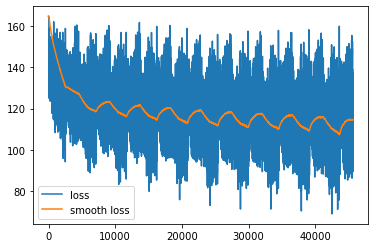

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(iteri, lossi)
plt.plot(iteri, smoothlossi)
plt.legend(['loss', 'smooth loss']);

## Reflection

I tried to train this model with three different datasets- datasets composed by random people's names, 10 pages of Harry Potter and the whole book of Atomic Habit. 

Clearly, this model is rubbish, because it's a character-level model, and the model size is very limited. It could generate nothing but bunch of meaningless outputs. 

However, there still exists a distinguishable gap between untrained and trained model in terms of their result. Model after being trained for several epochs started to capture the rough structure of names and sentences. The loss can decrease with my handcrafted backprop algorithms, which is nice.

In conclusion, I am quite satisfied with the outcome of this experiment, hope I can train a deeper word-level language model, with better architechture and produces meaningful result in the future. 